In [1]:
import sys
import numpy as np
import copy
%matplotlib nbagg
import matplotlib.pyplot as plt

pulse_building_folder = '/Users/natalie/Documents/PhD/Qdev/QcodesRelated/PulseBuilding'
if pulse_building_folder not in sys.path:
    sys.path.insert(0, pulse_building_folder)

from pulse_building import Waveform, Element, Sequence, Segment
from pulse_building import flat, gaussian, gaussian_derivative 

### Some settings:

In [2]:
p_dict = {'sample_rate': 1e9,
          'pulse_end': 5e-6,
          'pulse_readout_delay': 0,
          'marker_readout_delay': 0, 
          'readout_time': 1e-6, 
          'marker_time': 0.6e-6,
          'cycle_duration': 10e-6,
          'pi_pulse_duration': 10e-9,
          'sigma_cutoff': 4,
}

## First without segments:

### Readout Waveform and (the same used in all sequences)

In [3]:
readout_start = p_dict['pulse_end'] + p_dict['pulse_readout_delay']
resolution = 1 / p_dict['sample_rate']

readout_start_points = round(readout_start / resolution)
readout_points = round(p_dict['readout_time'] / resolution)

total_points = round(p_dict['cycle_duration'] / resolution)
marker_points = round(p_dict['marker_time'] / resolution)

pulse_end_points = round(p_dict['pulse_end'] / resolution)

readout_waveform = Waveform(length=total_points, channel=2)
readout_waveform.wave[readout_start_points:readout_start_points + readout_points] = 1
readout_waveform.add_marker(1, readout_start_points, marker_points)

### Readout Only

In [4]:
readout_sequence = Sequence(name='plain_readout', variable='')
element = Element()
element.add_waveform(readout_waveform)
readout_sequence.add_element(element)

### Rabi

In [5]:
rabi_sequence = Sequence(name='rabi',
                         variable='qubit pulse duration',
                         variable_unit='s',
                         step=1e-6,
                         start=0,
                         stop=5e-6)

qubit_duration_array_points = np.round(rabi_sequence.variable_array / resolution).astype(int)

for i, qubit_points in enumerate(qubit_duration_array_points):
    element = Element()
    element.add_waveform(readout_waveform)
    qubit_waveform = Waveform(length=total_points, channel=1)
    if i == 0:
        qubit_waveform.add_marker(1, 0, marker_points)
    qubit_start = pulse_end_points - qubit_points
    qubit_end = pulse_end_points
    qubit_waveform.wave[qubit_start:qubit_end] = 1
    element.add_waveform(qubit_waveform) 
    rabi_sequence.add_element(element)

## T1

In [6]:
t1_sequence = Sequence(name='t1',
                       variable='pi pulse readout delay',
                       variable_unit='s',
                       step=0.5e-6,
                       start=0,
                       stop=20e-6)

qubit_time = p_dict['pi_pulse_duration']
qubit_points = round(qubit_time / resolution)
delay_array_points = np.round(t1_sequence.variable_array / resolution).astype(np.int)

for i, delay_points in enumerate(delay_array_points):
    element = Element()
    element.add_waveform(readout_waveform)
    qubit_waveform = Waveform(length=total_points, channel=1)
    if i == 0:
        qubit_waveform.add_marker(1, 0, marker_points)
    qubit_start = pulse_end_points - delay_points - qubit_points
    qubit_end = pulse_end_points - delay_points
    qubit_waveform.wave[qubit_start:qubit_end] = 1
    element.add_waveform(qubit_waveform) 
    t1_sequence.add_element(element)


## With Segments

In [7]:
measurement_segment = Segment(name='cavity_measurement', gen_func=flat,
                     func_args={'amp':1, 'dur': p_dict['readout_time']},
                     time_markers={1: {'delay_time': [p_dict['marker_readout_delay']],
                                       'duration_time': [p_dict['marker_time']]}})

wait_segment_template = Segment(name='wait', gen_func=flat, func_args={'amp':0})


pi_gaussian_template = Segment(name='gaussian_pi_pulse', gen_func=gaussian,
                             func_args={'sigma_cutoff': p_dict['sigma_cutoff'],
                                        'amp': 1})

pi_half_gaussian_template = Segment(name='gaussian_pi_pulse', gen_func=gaussian,
                                  func_args={'sigma_cutoff': p_dict['sigma_cutoff'],
                                             'amp': 0.5})


# drag_pi_segment = Segment(name='pi_drag_pulse', gen_func=gaussian_derivative,
#                           func_args={'sigma': p_dict['pi_pulse_duration'],
#                                      'sigma_cutoff': p_dict['sigma_cutoff'],
#                                      'amp': 0.2})

# drag_pi_half_segment = Segment(name='pi_half_drag_pulse', gen_func=gaussian_derivative,
#                               func_args={'sigma': p_dict['pi_pulse_duration'],
#                                          'sigma_cutoff': p_dict['sigma_cutoff'],
#                                          'amp': 0.1})

# pi_square_segment = Segment(name='square_pi_pulse', gen_func=flat,
#                            func_args={'amp': 1, 'dur':  p_dict['pi_pulse_duration']})

# pi_half_square_segment = Segment(name='square_pi_half_pulse', gen_func=flat,
#                                func_args={'amp': 0.5, 'dur':  p_dict['pi_pulse_duration']})

### Some functions for making a sequence with something being varied

In [32]:
def make_time_varying_sequence(element_template, vary_ch, vary_seg, compensate_seg,
                               arg_to_vary, start, stop, step, total_time, marker_ch=4, marker_points=100):
    sequence = Sequence(variable=arg_to_vary, start=start, stop=stop, step=step)
    for i, val in enumerate(sequence.variable_array):
        elem = element_template.copy()
        elem[vary_ch].segment_list[vary_seg].func_args[arg_to_vary] = val
        elem[vary_ch].segment_list[compensate_seg].func_args["dur"] = total_time - elem[vary_ch].duration
        if i == 0:
            elem[marker_ch].add_marker(2, 0, marker_points)
        sequence.add_element(elem)
    return sequence

In [9]:
def make_varying_sequence(element_template, vary_ch, vary_seg,
                        arg_to_vary, start, stop, step, marker_ch=4, marker_points=100):
    sequence = Sequence(variable=arg_to_vary, start=start, stop=stop, step=step)
    for i, val in enumerate(sequence.variable_array):
        elem = element_template.copy()
        elem[vary_ch].segment_list[vary_seg].func_args[arg_to_vary] = val
        if i == 0:
            elem[marker_ch].add_marker(2, 0, marker_points)
        sequence.add_element(elem)
    return sequence

In [69]:
def make_multi_varying_sequence(element_template,
                                vary_ch_1, vary_seg_1, arg_to_vary_1, start1, stop1, step1, 
                                vary_ch_2, vary_seg_2, arg_to_vary_2, start2, stop2, step2,
                                marker_ch=4, marker_points=100):
    sequence = Sequence(variable=arg_to_vary, start=start1, stop=stop1, step=step1)
    second_varying_array = np.linspace(start2, stop2, num=round(abs(stop2 - start2) / step2 + 1))
    for i, val in enumerate(sequence.variable_array):
        elem = element_template.copy()
        elem[vary_ch_1].segment_list[vary_seg_1].func_args[arg_to_vary_1] = val
        elem[vary_ch_2].segment_list[vary_seg_2].func_args[arg_to_vary_2] = second_varying_array[i]
        if i == 0:
            elem[marker_ch].add_marker(2, 0, marker_points)
        sequence.add_element(elem)
    return sequence

### Single waveform for readout (on a single element and in a 'sequence')

In [10]:
wait1_segment = wait_segment_template.copy()
wait2_segment = wait_segment_template.copy()

measure_wf_s = Waveform(channel=4, segment_list=[wait1_segment, measurement_segment, wait2_segment],
                      sample_rate=p_dict['sample_rate'])

time_after_readout = (p_dict['cycle_duration'] - p_dict['pulse_end'] - 
                      p_dict['pulse_readout_delay'] - p_dict['readout_time'])
wait1_segment.func_args['dur'] = p_dict['pulse_end'] + p_dict['pulse_readout_delay']
wait2_segment.func_args['dur'] = time_after_readout

measure_elem_s = Element()
measure_elem_s.add_waveform(measure_wf_s)

readout_sequence_s = Sequence()
readout_sequence_s.add_element(measure_elem_s)

### Rabi

In [20]:
wait_segment = wait_segment_template.copy()
wait_segment.func_args['dur'] = p_dict['cycle_duration'] - p_dict['pulse_end']
rabi_wf = Waveform(channel=1, segment_list=[wait_segment_template, pi_gaussian_template, wait_segment])

In [21]:
rabi_element = Element()
rabi_element.add_waveform(measure_wf_s)
rabi_element.add_waveform(rabi_wf)
rabi_element.sample_rate = p_dict['sample_rate']

In [28]:
rabi_sequence_s = make_time_varying_sequence(rabi_element, 1, 1, 0, 'sigma', 0, 100e-9, 1e-9, 
                                             p_dict['cycle_duration'], )

In [25]:
# Or if you wanted to do this explicitly for some reason...

rabi_sequence_s = Sequence(name='rabi',
                         variable='qubit pulse duration',
                         variable_unit='s',
                         step=1e-9,
                         start=0,
                         stop=100e-9)

ch1_end_wait_seg = wait_segment_template.copy()
ch1_end_wait_seg.func_args['dur'] = p_dict['cycle_duration'] - p_dict['pulse_end']

ch1_wf_template = Waveform(channel=1,
                          segment_list=[ch1_end_wait_seg],
                          sample_rate=p_dict['sample_rate'])

for i, qubit_time in enumerate(rabi_sequence_s.variable_array):
    pi_pulse = pi_gaussian_template.copy()
    pi_pulse.func_args['sigma'] = qubit_time
    ch1_wf = ch1_wf_template.copy()
    ch1_wf.add_segment(pi_pulse, position=0)
    ch1_start_wait_seg = wait_segment_template.copy()
    ch1_start_wait_seg.func_args['dur'] = p_dict['cycle_duration'] - ch1_wf.duration
    ch1_wf.add_segment(ch1_start_wait_seg, position=0)
    element = Element()
    element.add_waveform(ch1_wf)
    if i == 0:
        ch4_wf = measure_wf_s.copy()
        ch4_wf.add_marker(1, 0, int(p_dict['marker_time'] * p_dict['sample_rate']))
        element.add_waveform(ch4_wf)
    else:
        element.add_waveform(measure_wf_s)
    rabi_sequence_s.add_element(element)

### T1

In [45]:
wait_segment = wait_segment_template.copy()
wait_segment.func_args['dur'] = p_dict['cycle_duration'] - p_dict['pulse_end']
pi_pulse = pi_gaussian_template.copy()
pi_pulse.func_args['sigma'] = p_dict['pi_pulse_duration']
t1_wf = Waveform(channel=1, segment_list=[wait_segment_template, pi_pulse,
                                          wait_segment_template.copy(), wait_segment])

In [46]:
t1_element = Element()
t1_element.add_waveform(measure_wf_s)
t1_element.add_waveform(t1_wf)
t1_element.sample_rate = p_dict['sample_rate']

In [53]:
t1_sequence_s = make_time_varying_sequence(t1_element, 1, 2, 0, 'dur', 0, 4e-6, 20e-9, p_dict['cycle_duration'])

### Plot here

<IPython.core.display.Javascript object>


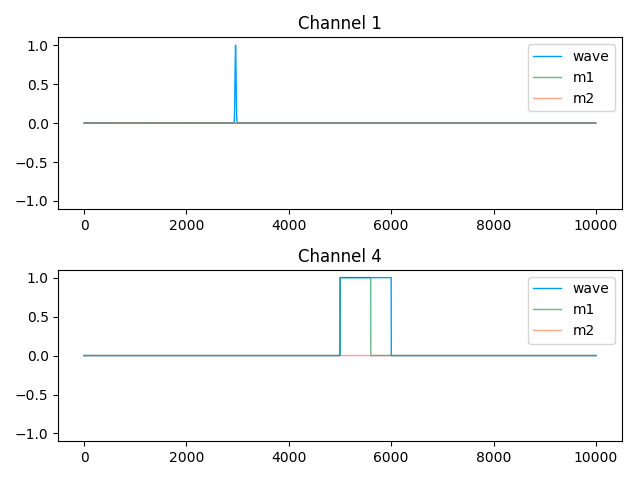

In [55]:
pl = t1_sequence_s.plot(elemnum=100, channels=[1, 4])

## Now with segments

In [10]:
rabi_sequence_s[1][1].segment_list[0].points

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])